In [15]:
import sys
sys.path.append('../src')

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import numpy as np
from glob import glob
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import Markdown
from skimage import io

from tqdm import tqdm
from geoq import gemini
from geoq import geom

world = geom.get_world()



# Evaluation

this is the evaluation flow

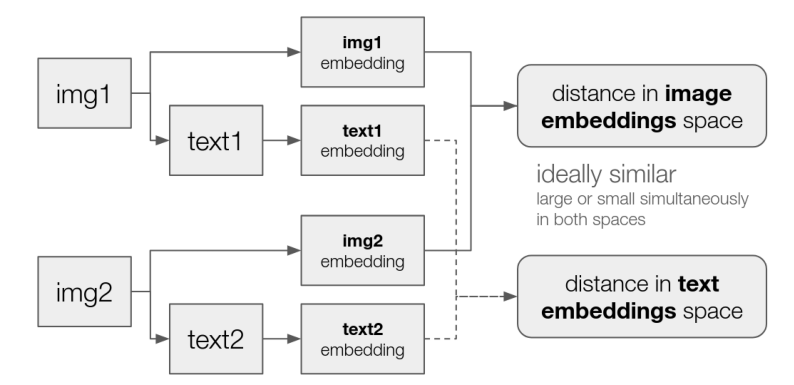

In [17]:
eval_img = io.imread("../imgs/evaluation.png")
plt.figure(figsize=(10,5))
plt.imshow(eval_img)
plt.axis("off");

## read all embeddings

In [4]:
files = glob('/datasets/genai-geo-embeddings/chips/*')
def readf(fname):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
        
    return {k: z[k] for k in ['chip_id', 'image_embedding', 'text_embedding', 'lonlat']}

embs = Parallel(verbose=5, n_jobs=-1)(delayed(readf)(fname) for fname in files)
embs = pd.DataFrame(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1131 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 3384 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6152 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 11576 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 19328 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 27680 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 36608 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 44867 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 45512 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 46178 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 46880 ta

In [5]:
tembs = np.r_[[np.r_[i] for i in embs.text_embedding.values]]
iembs = np.r_[[np.r_[i] for i in embs.image_embedding.values]]

In [6]:
tembs.shape, iembs.shape

((48313, 3072), (48313, 1024))

## sample pairs and measure distances

In [7]:
def evaluate(tembs, iembs, n_samples=100000):
    distances = {'text_space':[], 'image_space':[]}
    
    for _ in tqdm(range(n_samples)):
        i,j = np.random.randint(len(tembs), size=2)
        tdist = np.sqrt(((tembs[i] - tembs[j])**2).sum())
        idist = np.sqrt(((iembs[i] - iembs[j])**2).sum())
        
        distances['text_space'].append(tdist)
        distances['image_space'].append(idist)
    
    return distances
    

In [8]:
distances = evaluate(tembs, iembs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 63553.27it/s]


In [9]:
a,b = np.percentile(distances['text_space'], (1,99))
distances['text_space'] = (np.r_[distances['text_space']] - a)/(b-a)
a,b = np.percentile(distances['image_space'], (1,99))
distances['image_space'] = (np.r_[distances['image_space']] - a)/(b-a)


(-0.1, 1.1)

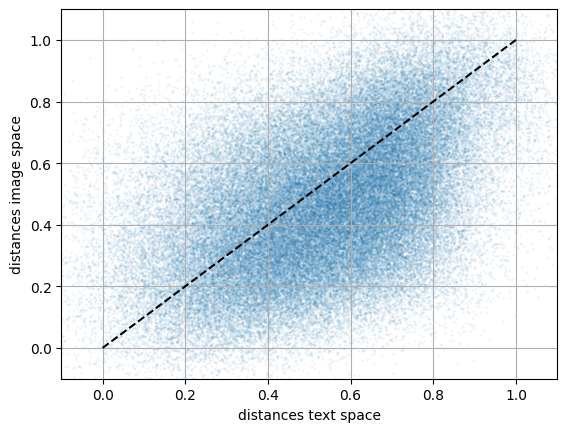

In [10]:
plt.scatter(distances['text_space'], distances['image_space'], s=1, alpha=.05)
plt.grid()
plt.xlabel('distances text space')
plt.ylabel('distances image space')
plt.plot([0,1],[0,1], color='black', ls='--')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

In [11]:
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

np.float64(0.46943532324508)

## compare a description prompt with one sample images

- send to gemini to generate a description for each image
- display the new description and the one in the dataset

In [12]:
generation_prompt =  """
describe this satellite image. 
include distinctive terrain features, natural and man made objects 
that will help relate this image to similar images and differentiate 
it from very different images
        """

In [13]:
gem = gemini.GeminiMultimodalModel(api_key='../../secrets/gemini.txt', generation_model_name='gemini-2.5-flash-lite')
gem.set_generation_prompt(generation_prompt)

In [14]:
file = np.random.choice(files)
with open(file, 'rb') as f:
    z = pickle.load(f)
descr = gem.generate_description_for_image(z['img'])


**compare descriptions**

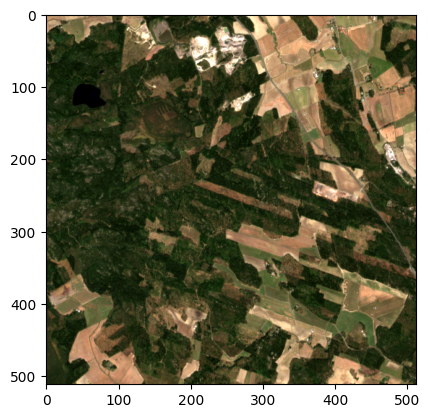

In [42]:
plt.imshow(z['img'])

In [43]:
print (descr)

This is a high-altitude satellite image of a rural landscape characterized by a mix of dense forest, agricultural fields, and some signs of human development.

**Dominant Features:**

*   **Forest:** Large areas are covered by dark green, dense forest, indicating a significant natural wooded area. The texture of the forest canopy appears relatively uniform in many places, suggesting mature trees.
*   **Agricultural Fields:** Interspersed within the forest are numerous agricultural fields. These fields vary in color, with some appearing as light brown or tan (suggesting tilled or harvested land) and others as patches of lighter green (possibly representing crops or pastures). The fields are often irregular in shape and size, reflecting the topography and historical land use patterns.
*   **Water Body:** A small, dark, irregularly shaped body of water is visible in the upper left portion of the image. This is likely a lake or pond, its dark color suggesting depth or the presence of veget

In [44]:
print (z['description'])

**Dominant Land Cover:**

The image is predominantly covered by forests (approximately 60%), with significant areas of agricultural land (approximately 30%) and some barren or disturbed land (approximately 10%).

**Terrain:**

The terrain appears to be gently undulating with some moderate hills, particularly in the western and central portions of the image. There are no prominent mountain ranges, valleys, or coastlines visible.

**Vegetation:**

*   **Forests:** Dense, dark green forests dominate the western and central parts of the image, covering roughly 60% of the area. These appear to be coniferous or mixed forests.
*   **Agricultural Fields:** Scattered throughout the image, especially in the eastern and southern sections, are numerous agricultural fields. These fields exhibit a variety of colors, including light brown (likely fallow or tilled land) and patches of green (suggesting crops). The fields are of varying sizes and shapes, often irregular, and appear to be a mix of culti

## evaluate a description prompt with 10 sample images

- get the description of each image with the new generation prompt
- make pairs and compute correlation between distance in text embeddings space and image embeddings space


In [59]:
descriptions_dir = '/datasets/genai-geo-embeddings/chips/'
files = glob(f'{descriptions_dir}/*.pkl')

# select sample imgs
files = np.r_[files][np.random.permutation(len(files))[:10]]
files

array(['/datasets/genai-geo-embeddings/chips/1ccc08b65735e.pkl',
       '/datasets/genai-geo-embeddings/chips/286da9bf00a2d.pkl',
       '/datasets/genai-geo-embeddings/chips/29b9e38fff478.pkl',
       '/datasets/genai-geo-embeddings/chips/1660af6b5b114.pkl',
       '/datasets/genai-geo-embeddings/chips/266bc2d189da0.pkl',
       '/datasets/genai-geo-embeddings/chips/37c9d191a4c01.pkl',
       '/datasets/genai-geo-embeddings/chips/2b6b371448c90.pkl',
       '/datasets/genai-geo-embeddings/chips/1bf5f3024925c.pkl',
       '/datasets/genai-geo-embeddings/chips/09f28ede386da.pkl',
       '/datasets/genai-geo-embeddings/chips/0a109a895f295.pkl'],
      dtype='<U54')

In [60]:
tembs_thisprompt = []
tembs_savedprompt = []
iembs = []

for file in tqdm(files):
    with open(file, 'rb') as f:
        z = pickle.load(f)
    descr = gem.generate_description_for_image(z['img'])

    temb = gem.get_embedding(descr)
    tembs_thisprompt.append(temb)
    iembs.append(z['image_embedding'])
    tembs_savedprompt.append(z['text_embedding'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


### correlation with the newly generated descriptions

In [61]:
distances = evaluate(tembs_thisprompt, iembs, n_samples=50)
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 22832.36it/s]


np.float64(0.7292474524899707)

### correlation with the descriptions stored in the dataset

In [62]:
distances = evaluate(tembs_savedprompt, iembs, n_samples=50)
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 23693.96it/s]


np.float64(0.7931415927052015)